In [1]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb 
import gc

In [2]:
def model(features, test_features, encoding = 'ohe', n_folds= 5):
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
            """
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()

        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)

    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']

        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics
            

In [3]:
import pandas as pd 
import numpy as np 

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

In [4]:
FILE_NAME = "preprocess.ipynb"
PARENT_DIR = os.path.abspath(os.path.join(os.path.dirname(FILE_NAME), "."))
app_train = pd.read_csv( PARENT_DIR + '/data/processed_train.csv')
app_test = pd.read_csv( PARENT_DIR + '/data/processed_test.csv')

In [5]:
submission, fi, metrics = model(app_train, app_test)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 240)
Testing Data Shape:  (48744, 240)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.799045	train's binary_logloss: 0.547522	valid's auc: 0.755303	valid's binary_logloss: 0.563216
Early stopping, best iteration is:
[233]	train's auc: 0.80437	train's binary_logloss: 0.542288	valid's auc: 0.755424	valid's binary_logloss: 0.560093
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798724	train's binary_logloss: 0.547996	valid's auc: 0.757872	valid's binary_logloss: 0.563524
Early stopping, best iteration is:
[211]	train's auc: 0.800521	train's binary_logloss: 0.546166	valid's auc: 0.758092	valid's binary_logloss: 0.562385
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.797919	train's binary_logloss: 0.549258	valid's auc: 0.762886	valid's binary_logloss: 0.564183
[400]	train's auc: 0.828584	train's binary_logloss: 0.519076	valid's auc: 0.762415	valid's bina

In [7]:
fi = fi.sort_values(by=['importance'])

In [10]:
fi

,feature,importance
239,DAYS_EMPLOYED_ANOM,0.0
183,ORGANIZATION_TYPE_Industry: type 13,0.0
84,FLAG_DOCUMENT_4,0.0
179,ORGANIZATION_TYPE_Industry: type 1,0.0
175,ORGANIZATION_TYPE_Emergency,0.0
...,...,...
11,DAYS_EMPLOYED,356.2
6,AMT_CREDIT,373.8
32,EXT_SOURCE_2,448.0
33,EXT_SOURCE_3,521.6


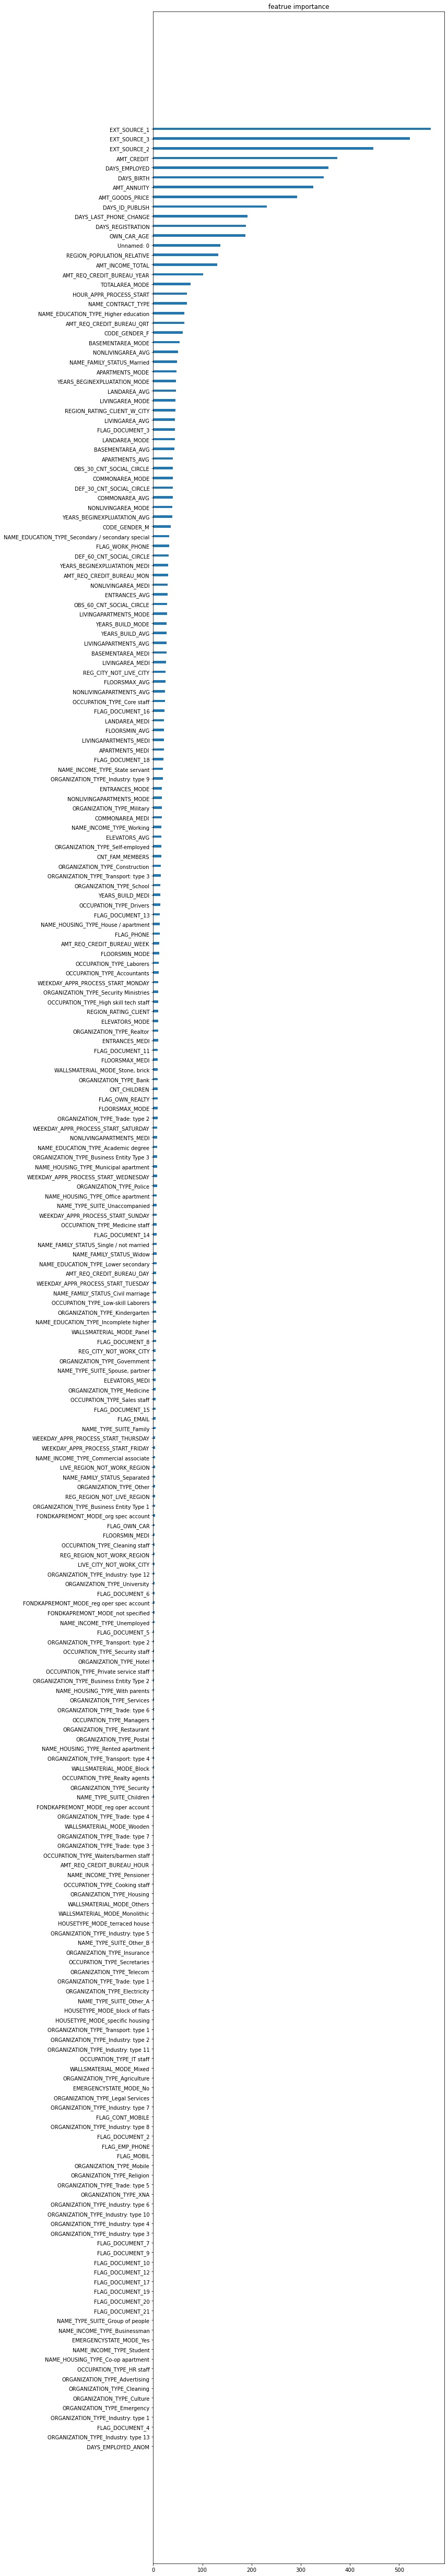

In [13]:
import matplotlib.pyplot as plt
# Display
plt.figure(figsize = (10, 90))
plt.bar( x=0, bottom=fi['feature'], height=0.25, width=fi['importance'], orientation="horizontal")
plt.title('featrue importance');

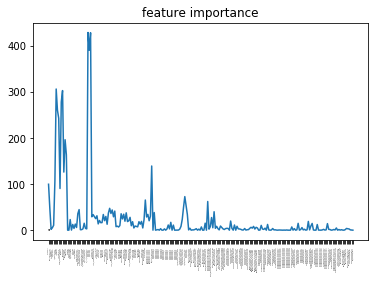

In [42]:
import matplotlib.pyplot as plt

fi_x = fi['feature']
fi_y = fi['importance']
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fi_x, fi_y)

plt.title('feature importance')
plt.xticks(rotation=90)
plt.xticks(fontsize= 1)
plt.savefig('featrue importance.png')

plt.show()


In [23]:
app_train

,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
0,0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,1,0,1,0,1,False
1,1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0,0,1,0,0,False
2,2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,False
3,3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,False
4,4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,307506,456251,0,0,0,0,157500.0,254700.0,27558.0,225000.0,...,0,0,0,0,1,0,1,0,0,False
307507,307507,456252,0,0,1,0,72000.0,269550.0,12001.5,225000.0,...,0,0,0,0,1,0,1,0,0,False
307508,307508,456253,0,0,1,0,153000.0,677664.0,29979.0,585000.0,...,0,0,0,1,0,0,1,0,0,False
307509,307509,456254,0,0,1,0,171000.0,370107.0,20205.0,319500.0,...,0,0,0,0,1,0,1,0,1,False


In [26]:
# calculate the accuracy
num_train = int(app_train.shape[0] * 0.7)
X_train = app_train[:num_train]
X_test = app_train[num_train:]
X_train

,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
0,0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,1,0,1,0,1,False
1,1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0,0,1,0,0,False
2,2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,False
3,3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,False
4,4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215252,215252,349421,0,1,1,0,180000.0,775327.5,32980.5,693000.0,...,0,0,0,0,0,1,1,0,0,False
215253,215253,349423,0,0,1,0,121500.0,197820.0,13896.0,180000.0,...,0,0,0,0,0,0,0,0,0,False
215254,215254,349424,0,0,1,0,121500.0,284400.0,22599.0,225000.0,...,0,0,0,1,0,0,1,0,0,False
215255,215255,349426,0,0,1,0,202500.0,508495.5,21541.5,454500.0,...,0,0,0,0,0,0,0,0,0,False


In [27]:
submission, fi, metrics = model(X_train, X_test)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (215257, 240)
Testing Data Shape:  (92254, 240)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.810896	train's binary_logloss: 0.537131	valid's auc: 0.752487	valid's binary_logloss: 0.559854
Early stopping, best iteration is:
[183]	train's auc: 0.807238	train's binary_logloss: 0.540774	valid's auc: 0.752747	valid's binary_logloss: 0.562028
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.81025	train's binary_logloss: 0.538254	valid's auc: 0.76024	valid's binary_logloss: 0.556187
Early stopping, best iteration is:
[195]	train's auc: 0.808957	train's binary_logloss: 0.539493	valid's auc: 0.760421	valid's binary_logloss: 0.556864
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.809976	train's binary_logloss: 0.537818	valid's auc: 0.755463	valid's binary_logloss: 0.555192
Early stopping, best iteration is:
[185]	train's auc: 0.806811	train's binary_logloss: 0.541013	

In [28]:
submission

,SK_ID_CURR,TARGET
215257,349428,0.127991
215258,349429,0.582460
215259,349430,0.132970
215260,349431,0.448735
215261,349434,0.106286
...,...,...
307506,456251,0.442091
307507,456252,0.645883
307508,456253,0.405931
307509,456254,0.433728


In [29]:
X_test['SK_ID_CURR']

215257    349428
215258    349429
215259    349430
215260    349431
215261    349434
           ...  
307506    456251
307507    456252
307508    456253
307509    456254
307510    456255
Name: SK_ID_CURR, Length: 92254, dtype: int64

In [30]:
X_test['TARGET']

215257    0
215258    0
215259    0
215260    0
215261    0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 92254, dtype: int64

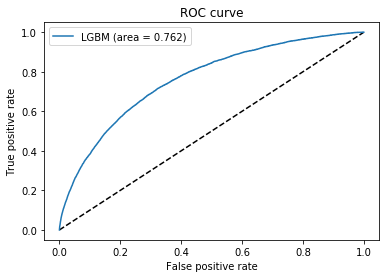

In [32]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(X_test['TARGET'], submission['TARGET'])
auc_lgbm = auc(fpr_lgbm, tpr_lgbm)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lgbm, tpr_lgbm, label='LGBM (area = {:.3f})'.format(auc_lgbm))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [45]:
fi.to_csv(PARENT_DIR + '/result/fi.csv', index= False)